In [1]:
# IRL AutoRegressive 4
# In this algorithm, a new bayesian infereence on the trajectory set is explored within the IRL
# Basically, the probability of any trajectory is now dependent on the other trajectories in the set.
# Full mathematical explanation is given below:

The Bayesian IRL:

In the old version of IRL we were aiming to maximize the likelihood of what is believed to be the optimal trajectory $\tau^*$ based on how we cange the weights $w$: 

$L(\tau^*|w) = \Large\frac{P(w|\tau^*)P(\tau^*)}{P(w)} = \frac{P(w, \tau^*)}{\sum_{i=1}^K P(w|\tau_i)P(\tau_i)} = \Large\frac{\exp(-w^T\Phi^*)}{\sum_i^K \exp(-w^T\Phi_i)}$

For new version, we condition all $P(\tau_i)$ on the full set of trajectories $\bar\tau$.
This means that now all the probabilities are considered conditional all trajectories, i.e., $P(\tau_i) \rightarrow P(\tau_i|\bar\tau)$.
So we have:

$P(\tau^*|w,\tau) = \Large\frac{P(w|\tau^*,\bar\tau)P(\tau^*|\bar\tau)}{P(w|\bar\tau)} = \frac{P(w|\tau^*,\tau)P(\tau^*|\tau)}{\sum_{j=1}^K P(w|\tau_j,\bar\tau)P(\tau_j|\bar\tau)}$

We can correctly assume that $w$ and $\bar\tau$ are conditionally independent. 
This means that when we have information about $\tau^*$, $\bar\tau$ has no additional information to offer for probability of $w$, hence:

$P(w|\tau*, \bar\tau) = P(w|\tau^*) \Rightarrow P(\tau^*|w,\tau) = \Large\frac{P(w|\tau^*)P(\tau^*|\tau)}{\sum_{j=1}^K P(w|\tau_j)P(\tau_j|\bar\tau)}$

Given Bayes Rule, we can rewrite $P(\tau_j|\bar\tau)$ as:

$P(\tau_j|\bar\tau) = \Large \frac{P(\bar\tau|\tau_j)P(\tau_j)}{P(\bar\tau)}$

$\Rightarrow \normalsize P(\tau^*|w,\tau) = 
\LARGE \frac{\frac{P(w|\tau^*)P(\bar\tau|\tau^*)P(\tau^*)}{P(\bar\tau)}}{\sum_{j=1}^K \frac{P(w|\tau_j)P(\bar\tau|\tau_j)P(\tau_j)}{P(\bar\tau)}} = \frac{P(w|\tau^*)P(\bar\tau|\tau^*)P(\tau^*)}{\sum_{j=1}^K P(w|\tau_j)P(\bar\tau|\tau_j)P(\tau_j)} = \frac{P(w, \tau^*)P(\bar\tau|\tau^*) }{\sum_{j=1}^K P(w,\tau_j)P(\bar\tau|\tau_j)} = \frac{\exp(-w^T\Phi^*)P(\bar\tau|\tau^*)}{\sum_{j=1}^K \exp(-w^T\Phi_j) P(\bar\tau|\tau_j)}$

We can already see the effect of considering the conditionality of the likelihood on $\bar\tau$ in the expression by comparing it to the old one.

We can assume that the likelihood of occurance for both $\bar\tau$ and $\tau_j$ are constant and equal to 1, but we can assume a conditional probability for their occurance. With this assumption, and Bayes Rule we have:

$P(\tau_j|\bar\tau) = P(\bar\tau|\tau_j)$

The expression on the left side addresses the probability of trajectory $\tau_j$ being resulted from a set of trajectories $\bar\tau$, while the expression on the right, means how likely it is that the trajectory set $\bar\tau$ contains a trajectory $\tau_j$. These definitions are the same in theory, which corroborates the equality above. 

For example, a set that has trajectories that are close to $\tau_j$ have a higher chance to have generated (or contained) this trajectory, rather than a set that has trajectories that are far away from $\tau_j$. This also means that trajectory $\tau_j$ is more likely to have been generated (or contained) in a set with close trajectories to it, rather than not.

If we define: $P(\bar\tau|\tau_j) = ***$.

So the with this new conditional probability of trajectories, the likelihood of trajectory $i$ in the set will be determined by:

$L(\tau_i|w,\tau) = \Large\frac{A}{B}$

In [2]:
import crocoddyl
import pinocchio
from IPython.display import HTML
import mim_solvers
import numpy as np
import random
from matplotlib import animation
from matplotlib import pyplot as plt
from PointMass_utils import *
from PointMass_model import *
from scipy.optimize import minimize
from scipy.optimize import Bounds

In [3]:
nx = 4
nu = 2
T = 40
start_point = np.array([0, 0, 0, 0])
target_low = np.array([10, 0, 0, 0])
target_high = np.array([10, 10, 0, 0])
obs_act = 1
obs0 = Obstacle(10, 8, 2, obs_act, 'Obs0')
obs1 = Obstacle(3, 2.5, 1, obs_act, 'Obs1')
obs2 = Obstacle(8, 7, 1, obs_act, 'Obs2')
obs3 = Obstacle(4.5, 7, 1, obs_act, 'Obs3')
obs4 = Obstacle(6, 4.5, 1, obs_act, 'Obs4')
obs5 = Obstacle(6.5, 9, 1, obs_act, 'Obs5')
obs6 = Obstacle(7.5, 3, 1, obs_act, 'Obs6')
obs7 = Obstacle(5, 1, 1, obs_act, 'Obs7')
obs8 = Obstacle(2.5, 2, 1, obs_act, 'Obs8')
obs_set = [obs1, obs2, obs3]#, obs4, obs5, obs6, obs7, obs8]
# obs_set = [obs0]
translation_cost = XReg(nx, target_high, 'trans_high')
xreg = XReg(nx, start_point, 'XReg')
ureg = UReg(nu, None, 'UReg')

cost_set = Costs()
cost_set.add_cost(translation_cost)
cost_set.add_cost(xreg)
cost_set.add_cost(ureg)
# cost_set.add_cost(obs0)
cost_set.add_cost(obs1)
cost_set.add_cost(obs2)
cost_set.add_cost(obs3)
# cost_set.add_cost(obs4)
# cost_set.add_cost(obs5)
# cost_set.add_cost(obs6)
# cost_set.add_cost(obs7)
# cost_set.add_cost(obs8)

nr = cost_set.nr

In [4]:
# Desired Weights
w_run_possibles = np.array([10, 1., 1., 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000])
w_term_possibles = np.array([2000, 1., 1., 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])
w_run = w_run_possibles[:nr]
w_term = w_term_possibles[:nr]
obs_set = obs_set[:nr]
# w_des = np.hstack([w_run, w_term])
w_des = (np.hstack([w_run, w_term])/(np.max(np.hstack([w_run, w_term])))).copy()
# w_des = (np.hstack([w_run, w_term])/(np.linalg.norm(np.hstack([w_run, w_term])))).copy()

In [5]:
samples = 10
xlims = [0, 10]
ylims = [0, 10]
x0 = start_point
u0 = np.array([0.0, 0.0])
timeStep = 5e-2
max_iter = 500
# XS_Set_optimal, US_Set_optimal = test_model_full(cost_set, obs_set, samples, xlims, ylims, T, w_des, timeStep, max_iter, with_callback = False)
# xs_optimal = XS_Set_optimal[0]
# us_optimal = US_Set_optimal[0]
xs_optimal, us_optimal, _ = get_results_from_model(cost_set, x0, u0, T, w_des, timeStep, max_iter, with_callback = True)

iter     merit         cost         grad      step    ||gaps||        KKT
   1  1.01000e+02  1.01000e+02  3.46624e+01  1.0000  0.00000e+00  9.96889e+00
   2  1.23346e+00  1.23346e+00  2.68043e+01  0.5000  2.68674e-14  3.88161e-01
   3  1.10462e+00  1.10462e+00  1.05886e+01  1.0000  3.17372e-08  6.81804e-02
   4  1.05873e+00  1.05873e+00  3.63198e+00  1.0000  1.98759e-08  2.36897e-02
   5  9.86632e-01  9.86632e-01  2.29585e+00  1.0000  7.14584e-09  1.46572e-02
   6  9.82170e-01  9.82170e-01  8.56072e-01  1.0000  4.45125e-09  3.12253e-03
   7  9.81945e-01  9.81945e-01  4.12706e-02  1.0000  1.53541e-09  2.37077e-04
 END  9.81944e-01  9.81944e-01  3.38650e-04   ----   6.75099e-11  1.37485e-06


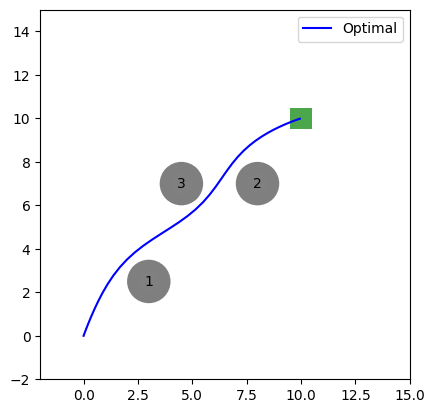

In [6]:
# HTML(animatePointMass(xs_optimal, obs_set, target_high).to_jshtml())
plot_1_traj(np.vstack(xs_optimal), obs_set, target_high, label='Optimal', linemap = 'b')

In [7]:
# Bad Running and Terminal Model
w_bad = np.zeros_like(w_des)
w_run = w_bad[:nr]
w_term = w_bad[nr:]

xs_non_optimal, us_non_optimal, sqp_non_opt = get_results_from_model(cost_set, x0, u0, T, w_bad, timeStep, max_iter, with_callback = False)

In [8]:
# HTML(animatePointMass(xs_non_optimal, obs_set, target_high).to_jshtml())
# plot_1_traj(np.vstack(xs_non_optimal), obs_set, target_high, label='Non-Optimal', linemap = 'r')

In [9]:
# IRL Algorithm
def pick_highs(opt_vals, num):
    vals = np.stack(opt_vals)
    inds = sorted(range(len(vals)), key=lambda i: vals[i])[-num:][::-1]
    return inds

def pick_lows(opt_vals, num):
    vals = np.stack(opt_vals)
    inds = sorted(range(len(vals)), key=lambda i: vals[i])[:num][::-1]
    return inds
    
def H_tau_star(phi_star, phis, alpha=1e-4):
    H = 0.0
    P = np.zeros(len(phis))
    for i, phi_ in enumerate(phis):
        P[i] = np.exp(alpha*(np.linalg.norm(phi_ - phi_star))**2)
    P = P/np.sum(P)
    for p in P:
        H -= p*np.log(p)
    return H, P

def P_taus(phi_star, phi_set, alpha=1e-4):
    P = np.zeros(len(phi_set))
    sum_star = 0.0
    sum_i = np.zeros(len(phi_set))
    for phi_ in phi_set:
        sum_star += np.linalg.norm(phi_star - phi_)**2
    for i, phi_i in enumerate(phi_set):
        for phi_ in phi_set:
            sum_i[i] += np.linalg.norm(phi_i - phi_)**2
    for i, phi_i in enumerate(phi_set):
        for phi_j in phi_set:
            P[i] += (-np.linalg.norm(phi_i - phi_j)**2)/(sum_i[i]) + (np.linalg.norm(phi_star - phi_j)**2)/(sum_star)
        
    print('sum_i: ', sum_i)
    print('sum_star: ', sum_star)

    P = sum_i - sum_star
    # sum_P = np.sum(P)
    # P = P/sum_P
    # P = np.exp(P)
    # P *= alpha
    return P

def get_phi_set(cost_set, xs, us, dt):
    phis = []
    for i, (X, U) in enumerate(zip(xs, us)):
        phis.append(cost_set.cum_feat(X, U, dt))
    return phis

def bayesian_likelihood(cost_set, x_opt, u_opt, xs_set, us_set, w_run, w_term, dt):
    phis = []
    costs = []
    # xs_w_opt = set_merge(x_opt, xs_set); us_w_opt = set_merge(u_opt, us_set)
    cost_opt, phi_opt = cost_set.traj_cost_and_feat(x_opt, u_opt, w_run, w_term, dt) 
    phis.append(phi_opt); costs.append(cost_opt)
    for x_, u_ in zip(xs_set, us_set):
        cost_nopt, phi_nopt = cost_set.traj_cost_and_feat(x_, u_, w_run, w_term, dt) 
        phis.append(phi_nopt); costs.append(cost_nopt)
    
    likelihood = 0.0
    num = 0.0
    den = 0.0

    # Tempering with Non-Optimals Manually
    coeff = [0.01]*len(costs); coeff[0] = 1
    # Normal Likelihood (P_tau_i_tau = 1)
    num = np.max([np.nextafter(0,1),np.exp(-cost_opt)])
    c = 0
    for phi_, cost_ in zip(phis, costs):
        den += np.max([np.nextafter(0,1),(np.exp(-cost_))])*coeff[c]
        c = c+1
    
    
    # # Bayesian Likelihood
    # P_tau = P_taus(phi_opt, phis, alpha = 1e-3)
    # num = (np.exp(-cost_opt))*P_tau[0]
    # for i, (phi_, cost_) in enumerate(zip(phis, costs)):
    #     den += (np.exp(-cost_))*P_tau[i]

    # # Test Bayesian Likelihood
    # normalizer = np.linalg.norm(phi_opt)
    # num = (np.exp(-cost_opt))
    # for phi_, cost_ in zip(phis, costs):
    #     den += (np.exp(-cost_))*np.exp(-((1/normalizer)*(np.linalg.norm(phi_opt - phi_))))

    likelihood = num/den
    return likelihood
            
def KL_D(cost_set, xs, us, w_old, w_new, dt):
    nr = cost_set.nr
    kl_array = np.zeros(len(xs))
    Px = np.zeros(len(xs))
    Qx = np.zeros(len(us))
    kl_div = 0.0
    for i, (X, U) in enumerate(zip(xs,us)):
        xs_temp = xs.copy(); xs_temp.pop(i)
        us_temp = us.copy(); us_temp.pop(i)
        Px[i] = bayesian_likelihood(cost_set, X, U, xs_temp, us_temp, w_old[:nr], w_old[nr:], dt)
        Qx[i] = bayesian_likelihood(cost_set, X, U, xs_temp, us_temp, w_new[:nr], w_new[nr:], dt)
    Px = Px/np.sum(Px)
    Qx = Qx/np.sum(Qx)
    kl_array = Px*np.log(Px/Qx)
    kl_div = np.sum(kl_array)
    return kl_div, kl_array


def fcn_w(x, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda = 0.001):
    nr = cost_set.nr
    output = 0
    likelihood = bayesian_likelihood(cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, x[:nr], x[nr:], dt)
    output -= np.log(likelihood)
    output += Lambda*np.linalg.norm(x)
    # output += Lambda*np.linalg.norm(x - w_old)
    return output


In [10]:
# dummy_x = [xs_optimal] * 10; 
# dummy_x[5] = xs[5]#; dummy_x[2] = xs[3]#; dummy_x[9] = xs_non_optimal; dummy_x[7] = xs_non_optimal
# dummy_u = [us_optimal] * 10; 
# dummy_u[5] = us[5]#; dummy_u[2] = us[3]#; dummy_u[9] = us_non_optimal; dummy_u[7] = us_non_optimal
# dummy_x = xs[20:35]; dummy_u = us[20:35]
# phis = get_phi_set(cost_set, dummy_x, dummy_u, dt)
# phi_star = cost_set.cum_feat(xs_optimal, us_optimal, dt)
# for phi_ in phis:
#     H, P = H_tau_star(phi_, phis, alpha = 1e-7)
#     plt.plot(P)
#     print(H)
# H, P = H_tau_star(phi_star, phis, alpha = 1e-7)
# plt.plot(P)
# plt.show()
# print(P)
# print(H)

In [11]:
dt = timeStep
Lambda = 0.0
lb = 0; ub = np.inf
bnds = Bounds(lb, ub)
options = {'maxiter': 2, 'iprint': -1,'ftol': 1e-10 ,'gtol' : 1e-10}
tol = 1e-10
pick_best = True
pick_worst = False

w0 = w_bad
w_prev = w0
it = 0
max_set_size = 5
# it_max_IRL = max_set_size + 1
it_max_IRL = 50
it_min_IRL = 5; it_min = True
it_max_sqp = 5

xs = []
us = []
xs_all = []
us_all = []
xs_non_optimal_set = []
us_non_optimal_set = []
ws = []
Fcns= []
KL_div = [10]; KL = 10
KL_arrs = []; KL_arrs.append(np.zeros(10))
Cost_Diffs = [1.0]
W_Diffs = [1.0]
Traj_Diffs = [1.0]
Opt_Vals = [1.0]


xs_all.append(np.vstack(xs_optimal).copy()); xs_all.append(np.vstack(xs_non_optimal).copy())
us_all.append(np.vstack(us_optimal).copy()); us_all.append(np.vstack(us_non_optimal).copy())
xs_non_optimal_set.append(np.vstack(xs_non_optimal).copy()); xs.append(np.vstack(xs_non_optimal).copy())
us_non_optimal_set.append(np.vstack(us_non_optimal).copy()); us.append(np.vstack(us_non_optimal).copy())

ws.append(w_bad)

best_x = xs_non_optimal
best_u = us_non_optimal

init_choices = ['bad','optimal','previous', 'best']
stochastic = False
damping = 5
loop_tol = 1e-8
w_diff = 1
traj_diff = 1
opt_feat = cost_set.cum_feat(xs_optimal,us_optimal,dt)
non_opt_feat = cost_set.cum_feat(xs_non_optimal, us_non_optimal, dt)
optimality = (np.linalg.norm(opt_feat - non_opt_feat))/(np.linalg.norm(opt_feat - non_opt_feat))
prev_optimality = optimality
prev_kld = 11; KL = 10
d_opt = 1
# while (np.abs(KL) > loop_tol and prev_optimality > optimality and it < it_max_IRL) or (it_min):
while (np.abs(KL) > loop_tol and it < it_max_IRL) or (it_min):

    # With simple regulation: ||w||
    res = minimize(fcn_w, 
                   w0, 
                   args=(cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda), 
                   bounds=bnds, 
                   method='L-BFGS-B', 
                   tol = tol,
                   options=options)

    dw = normalize(res.x.copy()) - w_prev
    w_loop = w_prev + (dw/damping)  
    # w_loop = w_prev + dw*np.min([optimality, 1.0/damping])
    w_loop = normalize(w_loop); w_run = w_loop[:nr]; w_term = w_loop[nr:]
    fcn_value = fcn_w(w_loop, cost_set, xs_optimal, us_optimal, xs, us, dt, Lambda); Fcns.append(fcn_value)
    
    # initial = random.choice(init_choices)
    initial = 'previous'
    if initial == 'previous':
        # Warm-Start with previous trajectory
        xs_init = [sqp_non_opt.xs.copy()[i] for i in range(T+1)]
        us_init = [sqp_non_opt.us.copy()[i] for i in range(T)]
    elif initial == 'optimal':
        # Warm-Start with optimal trajectory
        xs_init = [xs_optimal[i] for i in range(T+1)]
        us_init = [us_optimal[i] for i in range(T)]
    elif initial == 'bad':
        # Warm-Start with zero trajectory
        xs_init = [x0 for i in range(T+1)]
        us_init = [u0 for i in range(T)]
    elif initial == 'best':
        xs_init = [best_x[i] for i in range(T+1)]
        us_init = [best_u[i] for i in range(T)]
    

    sqp_non_opt = reset_weights(sqp_non_opt, w_loop[:nr], w_loop[nr:])
    done = sqp_non_opt.solve(xs_init, us_init, it_max_sqp)
    
    # Add the trajectory to the set
    xs.append(np.vstack(sqp_non_opt.xs.tolist().copy())); xs_all.append(np.vstack(sqp_non_opt.xs.tolist().copy()))
    us.append(np.vstack(sqp_non_opt.us.tolist().copy())); us_all.append(np.vstack(sqp_non_opt.us.tolist().copy()))
    ws.append(w_loop.copy())
    traj_feat = cost_set.cum_feat(sqp_non_opt.xs.tolist().copy(), sqp_non_opt.us.tolist().copy(), dt)
    optimality = (np.linalg.norm(traj_feat - opt_feat))/(np.linalg.norm(opt_feat - non_opt_feat)); Opt_Vals.append(optimality)

    opt_diff = (cost_set.traj_cost(sqp_non_opt.xs.copy(), sqp_non_opt.us.copy(), w_des[:nr], w_des[nr:], dt)- cost_set.traj_cost(xs_optimal, us_optimal, w_des[:nr], w_des[nr:], dt))**2; Cost_Diffs.append(opt_diff) 
    w_diff = np.linalg.norm(w_loop - w_prev); W_Diffs.append(w_diff)
    traj_diff = (sqp_non_opt.cost - cost_set.traj_cost(xs_optimal, us_optimal, w_loop[:nr], w_loop[nr:], dt))**2; Traj_Diffs.append(traj_diff)
    
    if it > 0:
        xs_w_opt = set_merge([xs_optimal], xs_non_optimal_set); us_w_opt = set_merge([us_optimal], us_non_optimal_set)
        # KL, KL_arr = KL_D(cost_set, xs_all, us_all, w_prev, w_loop, dt); KL_div.append(KL); KL_arrs.append(KL_arr)
        # KL, KL_arr = KL_D(cost_set, xs_non_optimal_set, us_non_optimal_set, w_prev, w_loop, dt); KL_div.append(KL); KL_arrs.append(KL_arr)
        KL, KL_arr = KL_D(cost_set, xs_w_opt, us_w_opt, w_prev, w_loop, dt); KL_div.append(KL); KL_arrs.append(KL_arr)
        KL_des, _ = KL_D(cost_set, xs_w_opt, us_w_opt, w_des, w_loop, dt)
        print('Iter: {} || KLD: {:.5f} || Desired KLD: {:.5f} || Traj Diff: {:.4f}, || Opt_Div: {:.4f} || Diff Opt_Div: {:.4f}'.format(
            it+1, KL, KL_des, traj_diff, optimality, d_opt
        ))

    if optimality < prev_optimality:
        best_x = sqp_non_opt.xs.copy()
        best_u = sqp_non_opt.us.copy()
    
    if len(xs) < max_set_size:
        xs_non_optimal_set = xs
        us_non_optimal_set = us
    else:
        if pick_best:
            inds = pick_lows(Opt_Vals,max_set_size)
            xs_non_optimal_set = [xs[i] for i in inds]
            us_non_optimal_set = [us[i] for i in inds]
        elif pick_worst:
            inds = pick_highs(Opt_Vals,max_set_size)
            xs_non_optimal_set = [xs[i] for i in inds]
            us_non_optimal_set = [us[i] for i in inds]
        else:
            xs_non_optimal_set = xs[-max_set_size:]
            us_non_optimal_set = us[-max_set_size:]
        
    d_opt = prev_optimality - optimality
    prev_optimality = optimality
    # Initial W for IRL as previous weights
    w0 = w_loop.copy()
    w_prev = w0
    it += 1
    if it > it_min_IRL:
        it_min = False

    

print(res)
w_irl = ws[-1]

Iter: 2 || KLD: 105.28140 || Desired KLD: 39.08903 || Traj Diff: 237.7367, || Opt_Div: 0.4086 || Diff Opt_Div: -4.4361
Iter: 3 || KLD: 0.00018 || Desired KLD: 23.18919 || Traj Diff: 138.0964, || Opt_Div: 0.3892 || Diff Opt_Div: 5.0275
Iter: 4 || KLD: 0.00090 || Desired KLD: 14.65169 || Traj Diff: 84.8579, || Opt_Div: 0.3712 || Diff Opt_Div: 0.0194
Iter: 5 || KLD: 0.00392 || Desired KLD: 11.94674 || Traj Diff: 56.2222, || Opt_Div: 0.3562 || Diff Opt_Div: 0.0181
Iter: 6 || KLD: 0.00666 || Desired KLD: 0.43559 || Traj Diff: 37.6754, || Opt_Div: 0.3421 || Diff Opt_Div: 0.0149
Iter: 7 || KLD: 0.00946 || Desired KLD: 0.21528 || Traj Diff: 25.0320, || Opt_Div: 0.3280 || Diff Opt_Div: 0.0142
Iter: 8 || KLD: 0.01319 || Desired KLD: 0.08844 || Traj Diff: 15.9786, || Opt_Div: 0.3133 || Diff Opt_Div: 0.0141
Iter: 9 || KLD: 0.01247 || Desired KLD: 0.02824 || Traj Diff: 9.2890, || Opt_Div: 0.2968 || Diff Opt_Div: 0.0147
Iter: 10 || KLD: 0.00465 || Desired KLD: 0.00977 || Traj Diff: 5.4206, || Opt_Di

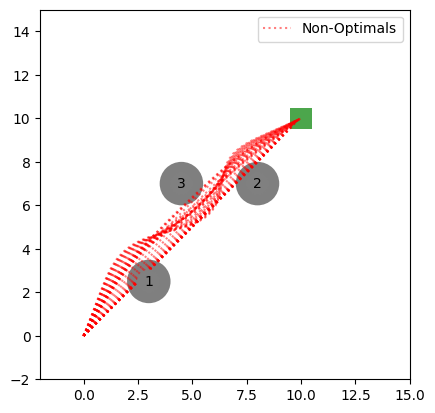

In [12]:
plot_1_set(xs, obs_set, target_high, label='Non-Optimals', linemap_traj='r:', linemap_set='r:')

In [13]:
n = KL_div.index(min(KL_div)); print(n); print(min(KL_div))
m = Opt_Vals.index(min(Opt_Vals)); print(m); print(min(Opt_Vals))
# plt.plot(KL_div)
# plt.plot(Opt_Vals)
# print(KL_div[m])

40
5.755730075643578e-09
23
0.10819881336237971


In [14]:
w_irl = ws[n]
for i, cost in enumerate(cost_set.costs):
    print(cost.name, ':')
    print('Running || ', 'Desired: ', w_des[:nr][i], 'IRL: ', w_irl[:nr][i])
    print('Terminal || ', 'Desired: ', w_des[nr:][i], 'IRL: ', w_irl[nr:][i])
    print('')

trans_high :
Running ||  Desired:  0.005 IRL:  0.0023718961260700937
Terminal ||  Desired:  1.0 IRL:  1.0

XReg :
Running ||  Desired:  0.0005 IRL:  0.0007071916415213604
Terminal ||  Desired:  0.0005 IRL:  0.0

UReg :
Running ||  Desired:  0.0005 IRL:  2.2360619071632264e-05
Terminal ||  Desired:  0.0005 IRL:  0.0

Obs1 :
Running ||  Desired:  1.0 IRL:  0.6964309765386524
Terminal ||  Desired:  0.5 IRL:  0.0

Obs2 :
Running ||  Desired:  1.0 IRL:  0.38458969314717123
Terminal ||  Desired:  0.5 IRL:  0.0041858200356245

Obs3 :
Running ||  Desired:  1.0 IRL:  0.8197627143868561
Terminal ||  Desired:  0.5 IRL:  0.0



In [15]:
print('Desired:                 ', fcn_w(w_des, cost_set, xs_optimal, us_optimal, xs, us, dt, Lambda)) 
print('IRL:                     ', fcn_w(w_irl, cost_set, xs_optimal, us_optimal, xs, us, dt, Lambda))
print('')
print('Desired Trajectory Cost: ', cost_set.traj_cost(xs_optimal, us_optimal, w_des[:nr], w_des[nr:], timeStep))
print('with IRL Weight:         ', cost_set.traj_cost(xs_optimal, us_optimal, w_irl[:nr], w_irl[nr:], timeStep))
print('')
print('IRL Trajectory Cost:     ', cost_set.traj_cost(xs[-1], us[-1], w_irl[:nr], w_irl[nr:], timeStep))
print('with Desired Weight:     ', cost_set.traj_cost(xs[-1], us[-1], w_des[:nr], w_des[nr:], timeStep))

Desired:                  0.24804884747789827
IRL:                      0.27203164035075944

Desired Trajectory Cost:  0.9819440585005923
with IRL Weight:          0.46855915279073057

IRL Trajectory Cost:      0.41880427010506677
with Desired Weight:      1.1922131197666035


processing the animation ... 
... processing done


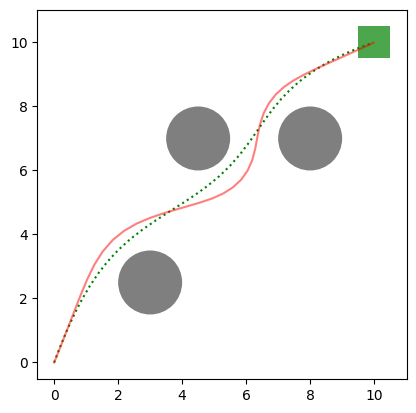

In [16]:
HTML(animateTraj(xs_optimal, xs[:-1], obs_set, target_high, max_set_size, sleep=500, animType=2).to_jshtml())

In [17]:
XS_Set, US_Set = test_model_full(cost_set, obs_set, samples, xlims, ylims, T, w_irl, timeStep, max_iter, with_callback = False)

10 Trajectories Collected
20 Trajectories Collected
Trajectory 23 Rejected
30 Trajectories Collected
Trajectory 33 Rejected
Trajectory 34 Rejected
40 Trajectories Collected
Trajectory 47 Rejected
Trajectory 48 Rejected
50 Trajectories Collected
60 Trajectories Collected
70 Trajectories Collected
Trajectory 77 Rejected
Trajectory 78 Rejected
80 Trajectories Collected
Trajectory 87 Rejected
90 Trajectories Collected
100 Trajectories Collected


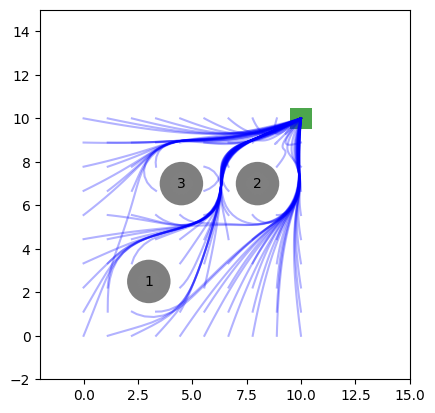

Number of Collisions: 0


In [18]:
plot_tested_model(XS_Set, obs_set, target_high)

In [19]:
# Testing
w_run = w_irl[:nr]
w_term = w_irl[nr:]
# w_run = w_des[:nr]
# w_term = w_des[nr:]
# w_run = ws[n][:nr]
# w_term = ws[n][nr:]

x0 = start_point
# x0 = np.array([5.0, 3.5, 0.0, 0.0])
u0 = np.array([0.0, 0.0])

xs_output, us_output, sqp = get_results_from_model(cost_set, x0, u0, T, w_irl, timeStep, max_iter, with_callback = True)

iter     merit         cost         grad      step    ||gaps||        KKT
   1  1.00474e+02  1.00474e+02  3.55488e+01  1.0000  0.00000e+00  9.98420e+00
   2  6.24529e-01  6.24529e-01  9.77332e+00  1.0000  1.98730e-14  8.08571e-02
   3  5.10382e-01  5.10382e-01  4.58254e+00  1.0000  2.21855e-08  2.30090e-02
   4  4.65645e-01  4.65645e-01  2.71140e+00  1.0000  6.97851e-09  5.08119e-03
   5  4.49440e-01  4.49440e-01  2.11848e+00  1.0000  5.64260e-09  2.35939e-03
   6  4.39598e-01  4.39598e-01  7.86457e+00  1.0000  5.80870e-09  8.87236e-03
   7  4.20837e-01  4.20837e-01  3.93723e+00  1.0000  1.75172e-08  4.80861e-03
   8  4.18690e-01  4.18690e-01  2.43696e+00  1.0000  8.61460e-09  2.56697e-03
   9  4.18521e-01  4.18521e-01  1.79376e-01  1.0000  5.86361e-09  1.68860e-04
 END  4.18518e-01  4.18518e-01  7.06058e-03   ----   3.87592e-10  5.90352e-06


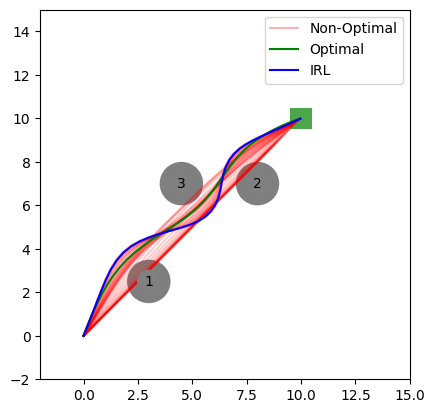

In [20]:
plot_results(xs_optimal, xs, xs_output, obs_set, target_high)

In [21]:
# creating sets
all_set_x = []
all_set_u = []
training_set_x = []
training_set_u = []

all_set_x.append(xs[-1]); all_set_x.append(xs_optimal); training_set_x.append(xs_optimal)
all_set_u.append(us[-1]); all_set_u.append(us_optimal); training_set_u.append(us_optimal)

for X, U in zip(xs, us):
    all_set_x.append(X); training_set_x.append(X)
    all_set_u.append(U); training_set_u.append(U)

In [22]:
P_irl = distributions(cost_set, xs_all, us_all, w_irl[:nr], w_irl[nr:], dt)
P_des = distributions(cost_set, xs_all, us_all, w_des[:nr], w_des[nr:], dt)

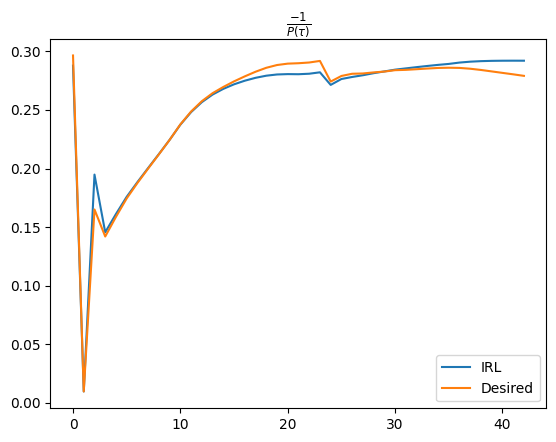

In [23]:
plt.plot(-1/np.log(P_irl),label='IRL')
plt.plot(-1/np.log(P_des),label='Desired')
plt.legend()
plt.gca().set_title(r'$\frac{-1}{P(\tau)}$')
plt.show()

In [24]:
# for A in KL_arrs:
#     plt.plot(A,label='KL')
# # plt.plot(KL_arrs[-5],label='KL')
# plt.hlines(y=0, xmin=0, xmax=len(A), linestyles=':')
# plt.show()

In [538]:
cov1 = np.cov(phis.T)
cov2 = get_cov(phis)

print(np.linalg.eig(cov1)[0])
print(np.linalg.eig(cov2)[0])

(6, 6)
[4.50650864e+06 2.45379574e+01 7.11587043e+00 4.13036617e-03
 5.34022963e-06 2.15687553e-06]
[4.05585778e+06 2.20841617e+01 6.40428339e+00 3.71732955e-03
 4.80620667e-06 1.94118798e-06]


In [539]:
k = 0.5
phis = np.stack(get_phi_set(cost_set, xs[-10:], us[-10:], dt))
mean = np.mean(phis,axis=0)
EV,b = np.linalg.eig(np.cov(phis.T))
print(EV)

EV_new = np.exp(k*(np.log(EV)))
print(EV_new)

phis_new = []
new_cov = b@np.diag(np.sqrt(EV_new))@b.T
for phi_ in phis:
    phis_new.append(new_cov@(phi_ - mean)+ mean)

phis_new = np.stack(phis_new)
mean_new = np.mean(phis_new,axis=0)
cov_new = np.cov(phis_new.T)
EV_new,_ = np.linalg.eig(cov_new)

[4.50650864e+06 2.45379574e+01 7.11587043e+00 4.13036617e-03
 5.34022963e-06 2.15687553e-06]
[2.12285389e+03 4.95358026e+00 2.66755889e+00 6.42679249e-02
 2.31089369e-03 1.46863050e-03]


In [540]:
print('old mean: ', mean)
print()
print('new mean: ', mean_new)

old mean:  [2.37288384e+03 2.82809701e+03 1.44190133e+04 2.73925254e-01
 4.51031734e-01 4.98140832e-01]

new mean:  [2.37288384e+03 2.82809701e+03 1.44190133e+04 2.73925254e-01
 4.51031734e-01 4.98140832e-01]


In [541]:
print('old eig: ', EV)
print()
print('new eig: ', EV_new)

old eig:  [4.50650864e+06 2.45379574e+01 7.11587043e+00 4.13036617e-03
 5.34022963e-06 2.15687553e-06]

new eig:  [9.56665941e+09 1.21550741e+02 1.89820034e+01 2.65449997e-04
 1.23209695e-08 3.16727879e-09]


In [542]:
print('old det: ', np.linalg.det(np.cov(phis.T)))
print()
print('new det: ', np.linalg.det(np.cov(phis_new.T)))

old det:  3.7435205376285934e-05

new det:  2.290409427170569e-07


In [558]:
def get_cov(X):
    m = get_mean(X)
    s = np.zeros(shape=(m.shape[0],m.shape[0]))
    for x in X:
        s += (x[:,None]-m[:,None])@(x[:,None]-m[:,None]).T
    s /= len(X)
    return s

def get_mean(X):
    m = np.zeros(shape=X[0].shape)
    for x in X:
        m += x
    m /= len(X)
    return np.squeeze(m)

[1.84657582 3.69684032]
[1. 1.]
[1. 1.]


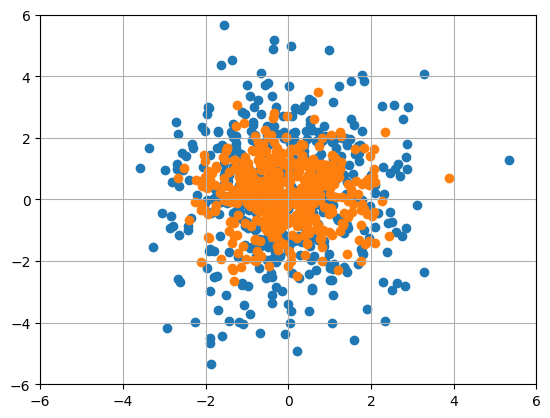

In [605]:
ps = np.random.multivariate_normal([0.0,0.0],[[2.0, 0.0],[0.0,4.0]],500)


m = get_mean(ps)
# print('Mean: ', m, 'Shape:', m.shape)
C = get_cov(ps)
# print('Cov: ', C, 'Shape:', C.shape)

k = 0.0
EV,b = np.linalg.eig(C)
print(EV)
EV_new = np.exp((k)*(np.log(EV)))
print(EV_new)

# C_p = b@(np.diag(EV_new))@b.T
C_p = b@(np.diag(np.sqrt(EV/EV_new)))@b.T
C_p = np.linalg.inv(C_p)

# m = np.array([-1, -1])

new_ps = []
for p in ps:
    new_p = p[:, None] - m[:,None]; new_p = C_p @ new_p; new_p += m[:,None]
    new_ps.append(np.squeeze(new_p))

new_ps = np.stack(new_ps)

new_m = get_mean(new_ps)
# print('Mean: ', new_m, 'Shape:', new_m.shape)
new_C = get_cov(new_ps)
# print('Cov: ', new_C)
print(np.linalg.eig(new_C)[0])

plt.scatter(ps[:,0], ps[:,1])
plt.scatter(new_ps[:,0], new_ps[:,1])
plt.grid()
plt.xlim([-6, 6])
plt.ylim([-6, 6])
plt.show()

In [554]:
ps[0].shape

(2,)